### To enhance restaurants' understanding of tipping behavior, helping tailor services and optimize operations develop a predictive model to estimate tip amounts in restaurants based on customer billing and demographic details.



In [1]:
## Libraries

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split  ## train_test_split function 

### preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error



In [2]:
## Loading the data 
data= pd.read_csv('tips.csv')
## available here    https://drive.google.com/file/d/1Xkm84DEOHqZ6YNnNP3jzerpUPU6LoCyJ/view 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [4]:
# Creating a label encoder instance
le = LabelEncoder()

# Encoding each categorical column
for column in ['sex', 'smoker', 'day', 'time']:
    data[column] = le.fit_transform(data[column])

# Displaying the encoded DataFrame
print(data.head())

   total_bill   tip  sex  smoker  day  time  size
0       16.99  1.01    0       0    2     0     2
1       10.34  1.66    1       0    2     0     3
2       21.01  3.50    1       0    2     0     3
3       23.68  3.31    1       0    2     0     2
4       24.59  3.61    0       0    2     0     4


<AxesSubplot:>

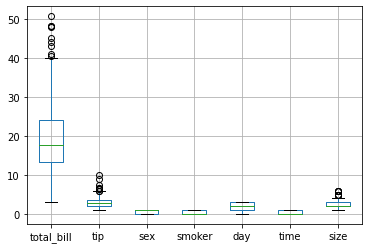

In [5]:
## Data Preparation 
## Outliers
data.boxplot()

In [6]:

# Function to find and remove outliers
def remove_outliers(df):
    # Identifying outliers
    outliers = pd.DataFrame()
    cleaned_df = df.copy()
    
    for column in df.select_dtypes(include='number').columns:
        # Calculate Q1, Q3, and IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        # Calculate bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers = pd.concat([outliers, column_outliers])
        
        # Remove outliers from the cleaned DataFrame
        cleaned_df = cleaned_df[~((cleaned_df[column] < lower_bound) | (cleaned_df[column] > upper_bound))]
    
    return outliers.drop_duplicates(), cleaned_df

# Get outliers and cleaned DataFrame
outliers, cleaned_df = remove_outliers(data)
print("\nDataFrame after removing outliers:")
print(cleaned_df)

## To remove duplicates 
cleaned_df.drop_duplicates()


DataFrame after removing outliers:
     total_bill   tip  sex  smoker  day  time  size
0         16.99  1.01    0       0    2     0     2
1         10.34  1.66    1       0    2     0     3
2         21.01  3.50    1       0    2     0     3
3         23.68  3.31    1       0    2     0     2
4         24.59  3.61    0       0    2     0     4
..          ...   ...  ...     ...  ...   ...   ...
238       35.83  4.67    0       0    1     0     3
240       27.18  2.00    0       1    1     0     2
241       22.67  2.00    1       1    1     0     2
242       17.82  1.75    1       0    1     0     2
243       18.78  3.00    0       0    3     0     2

[223 rows x 7 columns]


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2
4,24.59,3.61,0,0,2,0,4
...,...,...,...,...,...,...,...
238,35.83,4.67,0,0,1,0,3
240,27.18,2.00,0,1,1,0,2
241,22.67,2.00,1,1,1,0,2
242,17.82,1.75,1,0,1,0,2


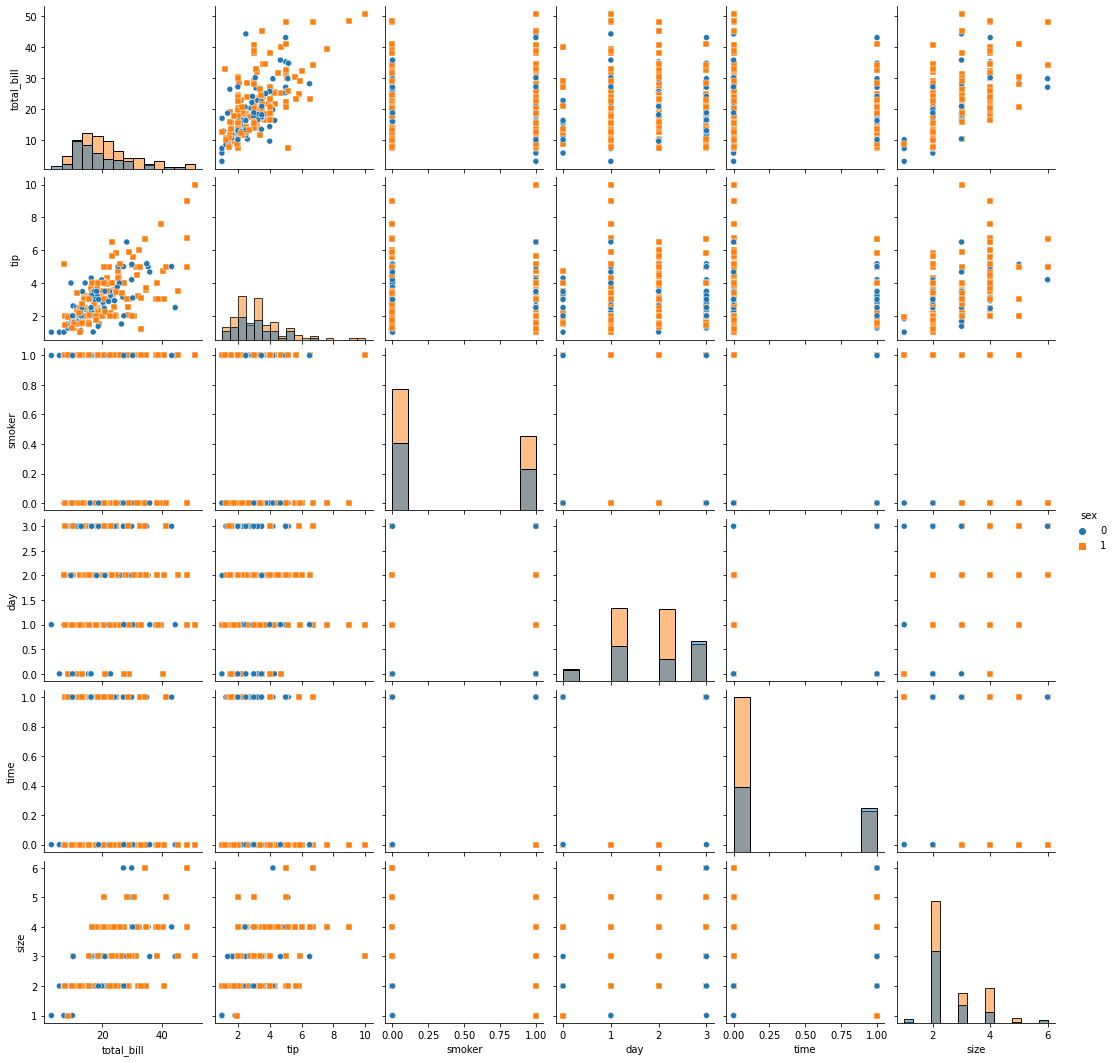

In [7]:
#### Bivariate Analysis 

## 1. Scater plot 

sns.pairplot(data, hue='sex', diag_kind='hist', kind='scatter', markers=["o", "s"])


From here we can see tip is highly  corelated with total bill and there is no corelation with size and tip.
so we can remove the column size.

And sex is somewhat corelated with tip


In [8]:
cleaned_df= cleaned_df.drop(columns='size', axis=1)

            total_bill       tip       sex    smoker       day      time
total_bill    1.000000  0.602944  0.141528  0.084578 -0.066637 -0.219143
tip           0.602944  1.000000  0.056455  0.042815 -0.003605 -0.141599
sex           0.141528  0.056455  1.000000  0.009837 -0.067593 -0.188808
smoker        0.084578  0.042815  0.009837  1.000000 -0.290316 -0.035580
day          -0.066637 -0.003605 -0.067593 -0.290316  1.000000  0.626530
time         -0.219143 -0.141599 -0.188808 -0.035580  0.626530  1.000000


<AxesSubplot:>

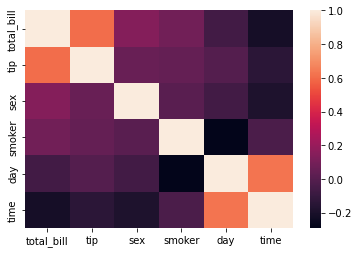

In [9]:
#corr_data= cleaned_df.corr(numeric_only=True)
numeric_df = cleaned_df.select_dtypes(include=['number'])
corr_data = numeric_df.corr()
print(corr_data)
sns.heatmap(corr_data)

<AxesSubplot:xlabel='total_bill', ylabel='tip'>

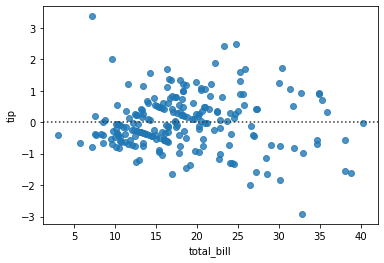

In [10]:
### residual plot

sns.residplot(x='total_bill', y='tip', data=cleaned_df)

Train test splitting and Modelling

In [11]:
x= cleaned_df.drop('tip',axis=1)
y=cleaned_df['tip']

x_train,x_test,y_train,y_test= train_test_split(x,y, test_size=0.2, random_state=42)

scaler= StandardScaler()

x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

### Linear regression

In [12]:
linear_reg= LinearRegression()
linear_reg.fit(x_train_scaled,y_train)
## prediction
y_pred_lin= linear_reg.predict(x_test_scaled)
print("Linear Regression R2 Score:", r2_score(y_test, y_pred_lin))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lin))

Linear Regression R2 Score: 0.4090469550149086
Linear Regression MSE: 0.5591395182555986


### Ridge Regression

In [13]:
lasso_reg= Ridge(alpha=0.1)
lasso_reg.fit(x_train_scaled,y_train)
y_pred_ridge= lasso_reg.predict(x_test_scaled)
print("Ridge Regression R2 Score:", r2_score(y_test, y_pred_ridge))
print("Ridge Regression MSE:", mean_squared_error(y_test, y_pred_ridge))

Ridge Regression R2 Score: 0.4089840344309563
Ridge Regression MSE: 0.5591990515557448


### Laso Regression

In [14]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x_train, y_train)
y_pred_lasso = lasso_reg.predict(x_test)
print("Lasso Regression R2 Score:", r2_score(y_test, y_pred_lasso))
print("Lasso Regression MSE:", mean_squared_error(y_test, y_pred_lasso))

Lasso Regression R2 Score: 0.42780964818984735
Lasso Regression MSE: 0.5413869010010797


###  Decision tree regression

In [15]:
decision_tree= DecisionTreeRegressor(random_state=42)
decision_tree.fit(x_train_scaled,y_train)
y_pred_tree = decision_tree.predict(x_test_scaled)
print("Decision Tree R2 Score:", r2_score(y_test, y_pred_tree))
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_tree))


Decision Tree R2 Score: 0.03499170348670633
Decision Tree MSE: 0.913057777777778


###  Random Forest 


In [16]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(x_train_scaled, y_train)
y_pred_rf = rf_reg.predict(x_test_scaled)
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))

Random Forest R2 Score: 0.29180739870905004
Random Forest MSE: 0.670067568444445


### Support Vector Regression (SVR)

In [17]:
# Feature Scaling for SVR
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel() 
## reshape bcz standard scaler need 2 D data nd y is just 1 column
##  ravel(bcz flatten back to 1D for the model)

svr_reg = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_reg.fit(x_train_scaled, y_train_scaled)
y_pred_svr = svr_reg.predict(x_test_scaled)
y_pred_svr = scaler.inverse_transform(y_pred_svr.reshape(-1, 1)).ravel()  # Inverse transform to get original scale

print("Scaled SVR R2 Score:", r2_score(y_test, y_pred_svr))
print("Scaled SVR MSE:", mean_squared_error(y_test, y_pred_svr))

Scaled SVR R2 Score: 0.3664619282908924
Scaled SVR MSE: 0.5994320110846504


### KNN

In [18]:
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(x_train_scaled, y_train)
y_pred_knn = knn_reg.predict(x_test_scaled)
print("KNN R2 Score:", r2_score(y_test, y_pred_knn))
print("KNN MSE:", mean_squared_error(y_test, y_pred_knn))

KNN R2 Score: 0.19043010552897677
KNN MSE: 0.7659872888888888


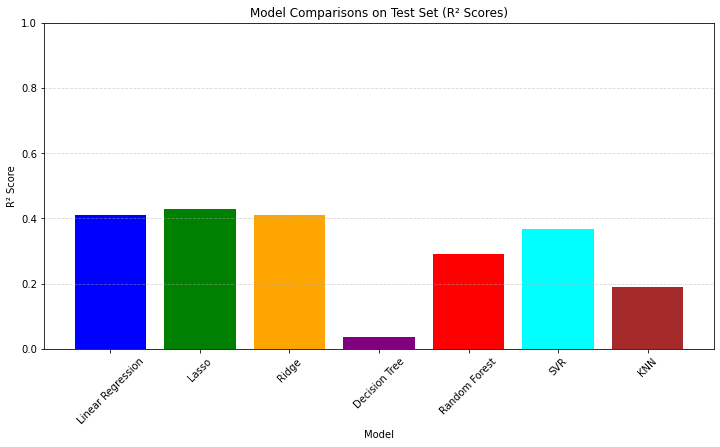

In [19]:
# Dictionary of model names and their respective R² scores on the test set
model_performance = {
    'Linear Regression': r2_score(y_test, y_pred_lin),
    'Lasso': r2_score(y_test, y_pred_lasso),
    'Ridge': r2_score(y_test, y_pred_ridge),
    'Decision Tree': r2_score(y_test, y_pred_tree),
    'Random Forest': r2_score(y_test, y_pred_rf),
    'SVR': r2_score(y_test, y_pred_svr),
    'KNN': r2_score(y_test, y_pred_knn)
}

# Plotting the R² scores
plt.figure(figsize=(12, 6))
plt.bar(model_performance.keys(), model_performance.values(), color=['blue', 'green', 'orange', 'purple', 'red', 'cyan', 'brown'])
plt.title('Model Comparisons on Test Set (R² Scores)')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.ylim(0, 1)  
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [20]:
model_performance

{'Linear Regression': 0.4090469550149086,
 'Lasso': 0.42780964818984735,
 'Ridge': 0.4089840344309563,
 'Decision Tree': 0.03499170348670633,
 'Random Forest': 0.29180739870905004,
 'SVR': 0.3664619282908924,
 'KNN': 0.19043010552897677}

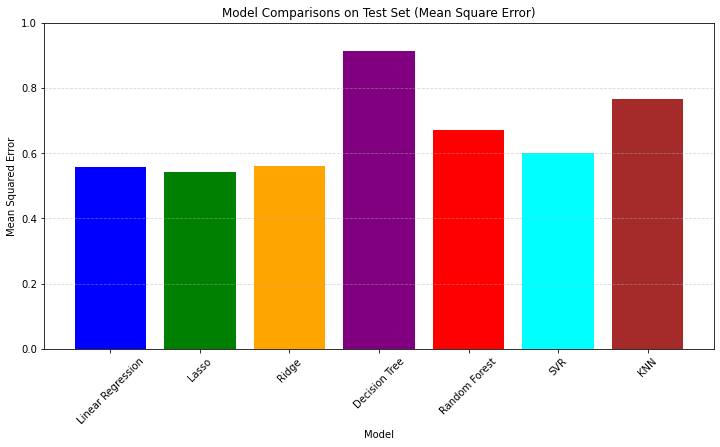

In [21]:
# Dictionary of model names and their respective Mean Squared Error on the test set
model_performance = {
    'Linear Regression': mean_squared_error(y_test, y_pred_lin),
    'Lasso': mean_squared_error(y_test, y_pred_lasso),
    'Ridge': mean_squared_error(y_test, y_pred_ridge),
    'Decision Tree': mean_squared_error(y_test, y_pred_tree),
    'Random Forest': mean_squared_error(y_test, y_pred_rf),
    'SVR': mean_squared_error(y_test, y_pred_svr),
    'KNN':mean_squared_error(y_test, y_pred_knn)
}

# Plotting the R² scores
plt.figure(figsize=(12, 6))
plt.bar(model_performance.keys(), model_performance.values(), color=['blue', 'green', 'orange', 'purple', 'red', 'cyan', 'brown'])
plt.title('Model Comparisons on Test Set (Mean Square Error)')
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.ylim(0, 1)  
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Models
1. Best Model: Lasso Regression performs the best, with the lowest MSE and highest R² score among the models.
2. Worst Model: The Decision Tree shows the worst performance with a very high MSE and an R² near zero, indicating significant overfitting or poor generalization.
3. Ensemble Models: Random Forest outperforms Decision Tree but is not the best compared to simpler linear models in this case.

## Conclusion of the analysis

1. Identify which factors significantly impact tip amounts.
- From the above correlation matrix we can conclude that total bill is significantly correlated with the tip amounts (Coefficient= 0.6)

2. Prediction Accuracy: Build and evaluate models to forecast tips effectively.
- According to models accuracy Lass regression is performing well for tips forecast.

3. Insights for Management: Provide actionable insights to improve customer service strategies and revenue management.
Here’s a refined version of your insights:

- **Segmentation of Smokers and Non-Smokers**: To enhance customer satisfaction, it would be beneficial to separate smokers from non-smokers by offering designated smoking-free areas. This will improve the dining experience for non-smokers and create a more comfortable environment for smokers.

- **Personalized Customer Interaction**: The dataset suggests that the party size does not significantly impact the tip amount. Therefore, staff should focus on improving the quality of customer interactions, ensuring personalized and attentive service to all customers, regardless of their party size.

- **Consistent Service Quality**: While the time of day (e.g., dinner vs lunch) does not appear to strongly influence tips, it highlights the importance of maintaining high-quality service throughout all hours of operation. A proactive approach to customer service should be prioritized at all times to ensure satisfaction and optimize tip potential.

- **Safety and Comfort for Female Customers**: Given that female customers may have different preferences or concerns, it is crucial to consider their comfort and safety, especially in environments where smoking might be allowed. Providing a secure and smoke-free area for female guests will help in creating a more welcoming and positive experience. 

These actionable insights can help improve both customer service strategies and revenue management.
